#### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

In [2]:
def plot_confustion_matrix(y_true, y_pred):
    c_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = [f'Count {value}' for value in c_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()


def test_logistic_regression(x, y, **kwargs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
    log_regr = LogisticRegression(**kwargs)
    log_regr.fit(x_train, y_train)
    predictions = log_regr.predict(x_test)
    scores = f1_score(y_test, predictions)
    print(scores)
    plot_confustion_matrix(y_test, predictions)


def test_support_vector_machine(x, y, **kwargs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
    clf_svm = SVC(**kwargs)
    clf_svm.fit(x_train, y_train)
    predictions = clf_svm.predict(x_test)
    scores = f1_score(y_test, predictions)
    print(scores)
    plot_confustion_matrix(y_test, predictions)


#### READ DATA

In [3]:
test_df = pd.read_csv('./data/class_test.csv')
train_df = pd.read_csv('./data/class_train.csv')
imbalanced_df = pd.concat([test_df, train_df])

#### ANALYSE DATA

#### PREPROCESSING

###### 1. HANDLE CLASS IMBALANCE

In [4]:
imbalanced_df['Outcome'].value_counts()

1    64
0    52
Name: Outcome, dtype: int64

##### Scaling Data

In [5]:
X = imbalanced_df.copy()   
y = X.pop('Outcome')
column_names = X.columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_data, columns=column_names)
X = scaled_df.copy()

In [17]:
X.head()

,Plasma renin activity,Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,Oxygen saturation,17α-Hydroxyprogesterone,Anti ds-DNA,Reticulocyte hemoglobin equivalent,Fibrinogen,Procalcitonin,SHBG -more detailed ranges in SHBG article,[H+],...,LDL cholesterol (Not valid when triglycerides >5.0 mmol/L),Luteinizing hormone (LH)-more detailed menstrual cycle ranges in separate diagram,Alpha 1-antitrypsin (AAT),Eosinophil cationic protein (ECP),Absolute content of carbon dioxide (CO2),Chloride (Cl),Amylase,IgM,Copper (Cu),Viscosity
0,0.119677,0.537972,0.286844,0.111533,0.138574,0.101218,0.105605,0.157789,0.115961,0.222800,...,0.085073,0.101458,0.443036,0.089212,0.040215,0.134039,0.181125,0.122402,0.548806,0.103644
1,0.108630,0.259043,0.304392,0.103382,0.129793,0.096082,0.097498,0.150159,0.116135,0.199430,...,0.092035,0.095323,0.269117,0.078057,0.176040,0.117352,0.275139,0.115869,0.005769,0.095488
2,0.607670,0.466263,0.315473,0.524005,0.583892,0.599349,0.788295,0.732774,0.559454,0.836479,...,0.436535,0.527800,0.149300,0.717546,0.381515,0.588069,0.058905,0.611634,0.510261,0.597214
3,0.213511,0.684021,0.148666,0.202545,0.205403,0.223782,0.203773,0.219672,0.238798,0.286998,...,0.189777,0.211016,0.560010,0.204364,0.060718,0.200151,0.292122,0.211841,0.200666,0.222456
4,0.192886,0.646987,0.277569,0.152824,0.215972,0.157444,0.242930,0.282200,0.161855,0.333880,...,0.142608,0.135780,0.574673,0.170391,0.271242,0.182605,0.407151,0.205544,0.140823,0.148254


In [7]:
smote = SMOTE(random_state=42)
balanced_df, y_balanced = smote.fit_resample(X, y)
balanced_df['Outcome'] = y_balanced

C:\Users\mimslade\AppData\Local\Temp/ipykernel_24140/4233092054.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['Outcome'] = y_balanced


In [8]:
print(balanced_df.shape)
balanced_df['Outcome'].value_counts()

(128, 160)


0    64
1    64
Name: Outcome, dtype: int64

Testing logistic reduction without pca.


0.7200000000000001


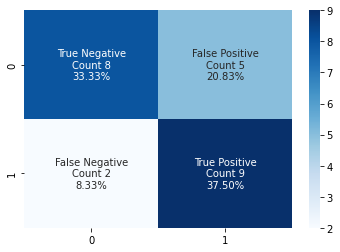

In [9]:
test_logistic_regression(X, y)

0.6896551724137931


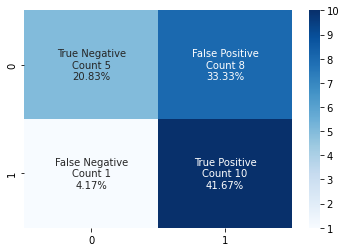

In [29]:
test_support_vector_machine(X, y, kernel='rbf')

###### 2. DIMENSION REDUCTION 

###### 2.1 PCA

In [11]:
nr_of_components = int(min(X.shape[0], X.shape[1]) * 0.8)
pca = PCA(nr_of_components)
pca.fit(X)

PCA(n_components=92)

##### Using Kneevalue to find convergence in number of components for pca

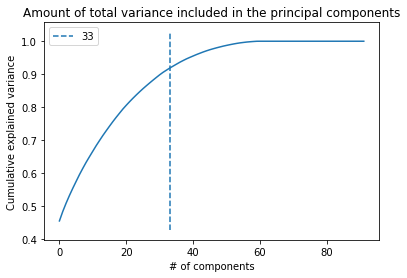

With 33 number of components we keep 91.88045531029978% of the information 
(116, 35)


In [12]:
ratios = np.cumsum(pca.explained_variance_ratio_)
kneedle = KneeLocator(range(len(ratios)), ratios, curve="concave", direction='increasing')
plt.plot(range(len(ratios)), ratios)
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label=kneedle.knee)
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.title("Amount of total variance included in the principal components")
plt.legend()
plt.show()
print(f'With {kneedle.knee} number of components we keep {ratios[kneedle.knee] * 100 }% of the information ')

reduced_X = pca.transform(X)
reduced_X = reduced_X[:,:35]
print(reduced_X.shape)

0.7407407407407406


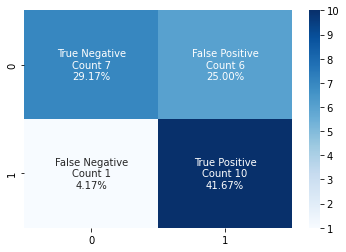

In [13]:
test_logistic_regression(reduced_X, y)

0.6896551724137931


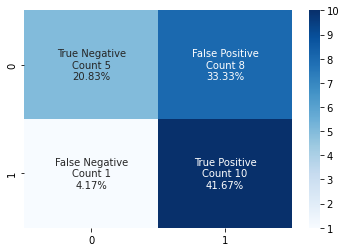

In [28]:
test_support_vector_machine(reduced_X, y, kernel='rbf')

In [23]:
test_copy_X = imbalanced_df.copy()   
test_copy_y = test_copy_X.pop('Outcome')
column_names = test_copy_X.columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(test_copy_X)
test_scaled_df = pd.DataFrame(scaled_data, columns=column_names)

masks = []
for variant in np.linspace(0.022, 0.075, num=10):
    selection = VarianceThreshold(threshold=variant)
    feature_sel_X = selection.fit_transform(test_scaled_df)
    print(feature_sel_X.shape)
    masks.append(selection.get_support())

#test_df = test_copy.iloc[:, mask]
#test_df.head()

(116, 154)
(116, 61)
(116, 55)
(116, 46)
(116, 36)
(116, 23)
(116, 9)
(116, 2)
(116, 2)
(116, 1)


0.7586206896551725


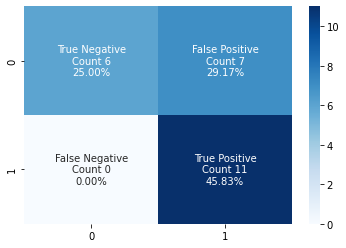

0.6666666666666667


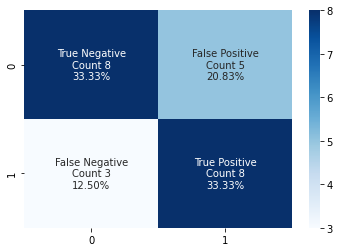

0.5185185185185185


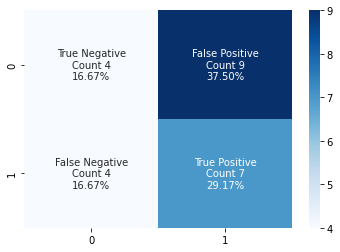

0.4444444444444444


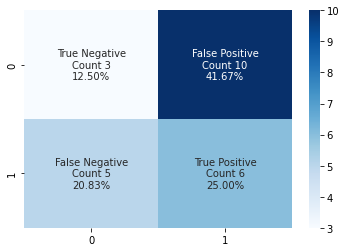

0.4615384615384615


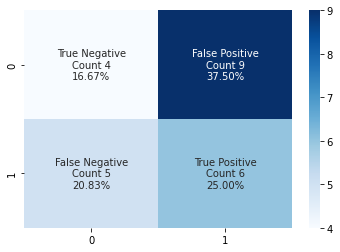

0.5384615384615385


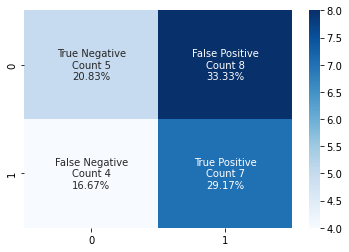

0.6153846153846153


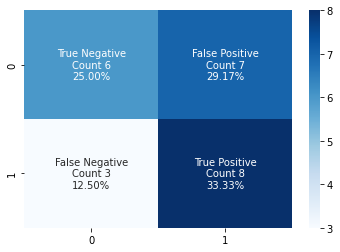

0.6285714285714286


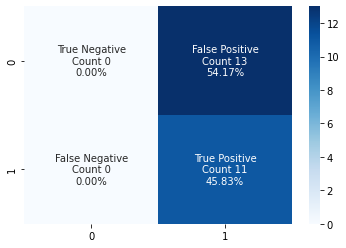

0.6285714285714286


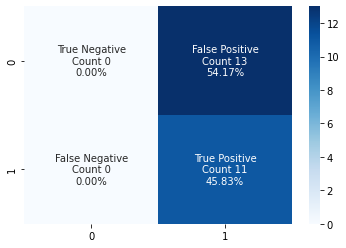

0.6285714285714286


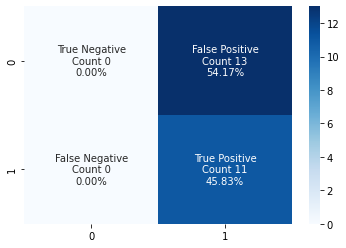

,Gamma glutamyl transferase (GGT)
0,0.229401
1,15.159877
2,2.115486
3,14.147901
4,7.762371


In [26]:
data_variants = []
for mask in masks:
    variant_df = test_copy_X.iloc[:, mask]
    #print(variant_df.shape)
    #data_variants.append(variant_df)

    test_support_vector_machine(variant_df, test_copy_y, kernel='linear')

variant_df.head()


###### 2.2 FEATURE SELECTION